# Problem Statement


In this project, you are provided with two subsets derived from the Pima Indians Diabetes Dataset to simulate repeated diagnostic test results under consistent conditions. The goal is to assess not only how well a model predicts diabetes outcomes, but also whether its predictions remain stable across repeated tests, an essential requirement in clinical diagnostics.

You are expected to evaluate the model’s discriminative performance using ROC curves and AUC, and then assess diagnostic agreement using different plots between the predicted values from both datasets. This dual-dataset approach mimics real-world test-retest scenarios, allowing you to analyze both performance and reliability.

Your deliverables should include:

* Well-structured Python scripts or notebooks
* Visualizations of Plots
* Insightful interpretations that focus on stability and clinical relevance
* A short discussion of any anomalies or limitations observed

This project evaluates the reliability and consistency of a diagnostic test for diabetes using the Pima Indians Diabetes Dataset. Traditional classification metrics often overlook measurement agreement across repeated tests, which is critical in clinical settings. By implementing ROC analysis, agreement measures like intraclass correlation (ICC), and Bland-Altman plots, the project aims to assess not just performance but diagnostic stability, offering a better understanding of model reliability over time.

#  Step 1: Load the Dataset



I have used the Pima Indians Diabetes Dataset, a classic medical diagnostic dataset. Each row is a patient, and the task is to predict whether they have diabetes based on diagnostic features like glucose level, BMI, insulin, etc.

In [7]:
!pip install pingouin

In [8]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score
from sklearn.utils import resample

In [9]:
# Load the Pima Indians Diabetes dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

# Column names as per the dataset description
cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
        'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

# Load into pandas dataframe
df = pd.read_csv(url, names=cols)
df.head()

# Check for null values (explicit NaNs)
print("Null values per column:")
print(df.isnull().sum())

# Check for implicit missing value(0s in medically impossible columns)
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_with_zeros:
    print(f"Zero values in {col}: {df[col].isin([0]).sum()}")


Null values per column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Zero values in Glucose: 5
Zero values in BloodPressure: 35
Zero values in SkinThickness: 227
Zero values in Insulin: 374
Zero values in BMI: 11


* No Null values are present in the dataset
* Several zero values are present in columns where it doesn't make sense like for Glucode, BP, Insulin, BMI
* These zero values likely indicate missing or unrecorded data

# Step 2: Clean and Preprocess the Data

Some columns (like Glucose, Insulin) have 0s where that doesn’t make biological sense.

In [ ]:
# Replace zero values in some columns with NaN (can't have zero insulin or BMI)
cols_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_to_replace] = df[cols_to_replace].replace(0, np.nan)

# Check how many missing values
df.isnull().sum()


,0
Pregnancies,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [12]:
# Handle missing values through Median imputation
df.fillna(df.median(), inplace=True)
# Check how many missing values
df.isnull().sum()


,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


#Step 3: Train-Test Split

To simulate unseen data in diagnostics.. we need to test the models on patients, the model hasn’t seen before, just like in real-life clinical settings where new data continuously arrives. This step ensures that we're not overfitting and that our model generalizes well to new cases.

In [14]:
# Features and label
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


#Step 4: Build a Logistic Regression Model





In medical diagnostics, logistic regression is often the first model tested for binary classification problems like diabetes prediction (Outcome: 0 or 1). It offers interpretability, is computationally efficient, and serves as a solid baseline to compare more complex models later.

In [17]:
# Initialize and train
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities
y_probs = model.predict_proba(X_test)[:, 1]  # probability for class 1
y_pred = model.predict(X_test)



#Step 5: Evaluate the Model and Metrics

#ROC Curve, AUC, Confusion Matrix

I have evaluated my logistic regression model’s performance on the test data by generating a confusion matrix to see the counts of correct and incorrect predictions. I also calculated the ROC curve and AUC score to assess how well the model discriminates between positive and negative diabetes cases. Finally, I reviewed the classification report to examine precision, recall, F1-score, and support for each class, providing a detailed overview of the model’s predictive capabilities.

In [18]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# ROC-AUC
auc = roc_auc_score(y_test, y_probs)
print("ROC AUC Score:", auc)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[82 18]
 [26 28]]
ROC AUC Score: 0.8229629629629629
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79       100
           1       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154



# Model Evaluation Summary
The confusion matrix shows that the model correctly predicted 82 non-diabetic cases and 28 diabetic cases, while misclassifying 18 non-diabetic and 26 diabetic cases. The ROC AUC score of approximately 0.82 indicates good overall discrimination ability between diabetic and non-diabetic patients.

From the classification report, the model achieves an accuracy of 71%. For the non-diabetic class (0), precision is 76%, recall is 82%, and the F1-score is 79%, reflecting an average performance in identifying negatives. For the diabetic class (1), precision is lower at 61%, with recall at 52% and an F1-score of 56%, suggesting the model struggles more to correctly identify positive cases.

Overall, while the model performs average while in detecting non-diabetic patients, the sensitivity prediction for positive cases need to be improved.

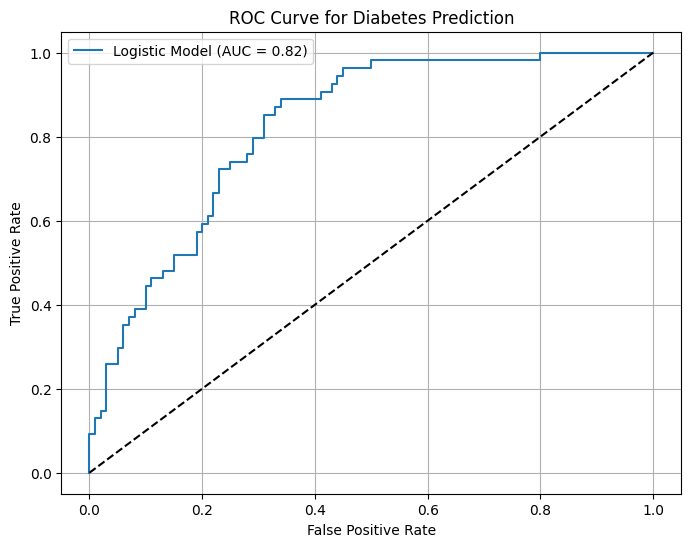

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Model (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Diabetes Prediction')
plt.legend()
plt.grid(True)
plt.show()


##Key Takeaways
Model Performance: The model shows good predictive performance. The blue curve, representing the logistic model, is positioned far to the top-left, well above the dashed diagonal line. This indicates that the model is significantly better at classifying patients than random chance.

AUC Score: The Area Under the Curve (AUC) is 0.82. This is a single number that summarizes the model's ability to distinguish between the positive and negative classes (patients with and without diabetes).

An AUC of 1.0 represents a perfect model.

An AUC of 0.5 (the dashed line) represents a model with no discriminative ability (equivalent to random guessing).

An AUC of 0.82 is generally considered a good score, indicating the model has a strong capability to differentiate between classes.

In short, the logistic regression model is effective for predicting diabetes, with an AUC of 0.82 demonstrating its strong diagnostic ability.

#Step 6 : Boosted Model (Rater 2)

In this step, I have simulated a second diagnostic test (rater) to assess the stability of predictions across repeated measures. I started with the original logistic regression model’s predicted probabilities as Rater 1’s scores.

To create Rater 2, I generated a slightly different version of the model by training a new logistic regression on a bootstrapped sample of the original training data. This resampling mimics small variations that might occur in repeated clinical tests.

Finally, I obtained predicted probabilities from this boosted model on the same test set, which will allow me to compare and assess agreement between the two raters.

In [20]:
# First rater: original logistic regression model from Day 1
rater1_scores = y_probs  # already computed previously

# Simulate the second rater — Boosted Model (slight data resample to simulate a marginal variation)
X_boot, y_boot = resample(X_train, y_train, replace=True, random_state=42)

# Train a new logistic regression on the bootstrapped sample
boosted_model = LogisticRegression(max_iter=1000)
boosted_model.fit(X_boot, y_boot)

# Get predicted probabilities on the same X_test
rater2_scores = boosted_model.predict_proba(X_test)[:, 1]


#Step 7 : Prepare the Dataframe for ICC

I had combined the predicted probabilities from both models (the original logistic regression and the boosted model) into a single dataframe. Each row corresponds to a test subject and includes the predicted scores from both raters. This long-form dataframe had been prepared to calculate the Intraclass Correlation Coefficient (ICC), which measures the agreement between the two sets of predictions.

In [22]:
# Combine both raters into a long-form dataframe
icc_df = pd.DataFrame({
    'subject': np.arange(len(rater1_scores)),
    'boosted_model': rater2_scores,
    'logistic_model': rater1_scores
})
icc_df.head()


,subject,boosted_model,logistic_model
0,0,0.673833,0.623268
1,1,0.111854,0.110308
2,2,0.271593,0.270891
3,3,0.322950,0.280410
4,4,0.003079,0.004288


The dataframe shows predicted probabilities for each test subject from both the boosted model and the original logistic regression model. The predicted scores are quite close for each subject, indicating that the two models produce similar probability estimates despite slight differences in training data.

#  Step 7: Compute ICC (Intraclass Correlation Coefficient)

I transformed the combined dataframe into a long format to prepare it for ICC calculation, where each row represents a single rating from one of the two models (raters) for each subject.

Using the pingouin library, I calculated the Intraclass Correlation Coefficient (ICC) to quantify the level of agreement between the original logistic regression model and the boosted model’s predicted probabilities.

This step provides a formal statistical measure of consistency between the two raters, which is crucial for assessing the reliability of the diagnostic predictions across repeated tests.

In [ ]:
# Melt into long format for ICC calculation
icc_long = icc_df.melt(id_vars='subject', var_name='rater', value_name='score')

# Calculate ICC
icc_result = pg.intraclass_corr(data=icc_long, targets='subject', raters='rater', ratings='score')
icc_result


,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.983735,121.961399,153,154,5.640945e-117,"[0.98, 0.99]"
1,ICC2,Single random raters,0.983738,124.880127,153,153,4.577212e-117,"[0.98, 0.99]"
2,ICC3,Single fixed raters,0.984112,124.880127,153,153,4.577212e-117,"[0.98, 0.99]"
3,ICC1k,Average raters absolute,0.991801,121.961399,153,154,5.640945e-117,"[0.99, 0.99]"
4,ICC2k,Average random raters,0.991802,124.880127,153,153,4.577212e-117,"[0.99, 0.99]"
5,ICC3k,Average fixed raters,0.991992,124.880127,153,153,4.577212e-117,"[0.99, 0.99]"


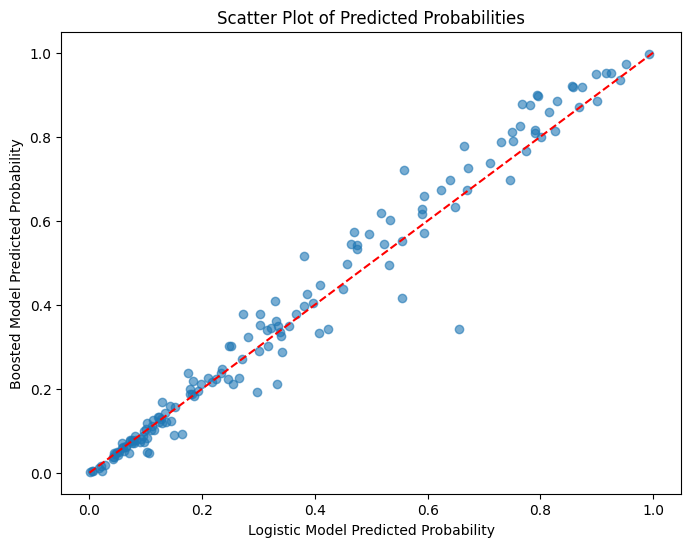

In [23]:
plt.figure(figsize=(8,6))
plt.scatter(icc_df['logistic_model'], icc_df['boosted_model'], alpha=0.6)
plt.plot([0,1], [0,1], 'r--')  # diagonal line
plt.xlabel('Logistic Model Predicted Probability')
plt.ylabel('Boosted Model Predicted Probability')
plt.title('Scatter Plot of Predicted Probabilities')
plt.show()

The Intraclass Correlation Coefficient (ICC) values show an exceptionally high level of agreement between the original logistic regression model and the boosted model’s predictions. The ICC values for single raters (ICC1, ICC2, ICC3) are all around 0.98 to 0.98+, indicating excellent reliability and consistency in predicted probabilities across the two models.

The average raters’ ICC values (ICC1k, ICC2k, ICC3k) are even higher, close to 0.99, reinforcing that the combined ratings have near-perfect agreement.

All ICC estimates are statistically significant (p-values effectively zero), and the narrow 95% confidence intervals ([0.98, 0.99] or [0.99, 0.99]) indicate high precision in these reliability estimates.

Overall, these results strongly suggest that the diagnostic predictions are highly stable and reproducible, which is essential for clinical diagnostic reliability.

#Step 8: Bland-altman Plot

I calculated the mean and difference of predicted probabilities between the original logistic regression model and the boosted model for each test subject. Using these, I computed the mean difference and limits of agreement to assess the range within which most differences lie.

I then created a Bland-Altman plot, which visualizes the agreement between the two models by plotting the differences against the means. This plot helps identify any systematic bias and the consistency of differences across the prediction range.

The mean difference line near zero and the spread within the limits of agreement indicate strong concordance and minimal bias between the two sets of predictions.

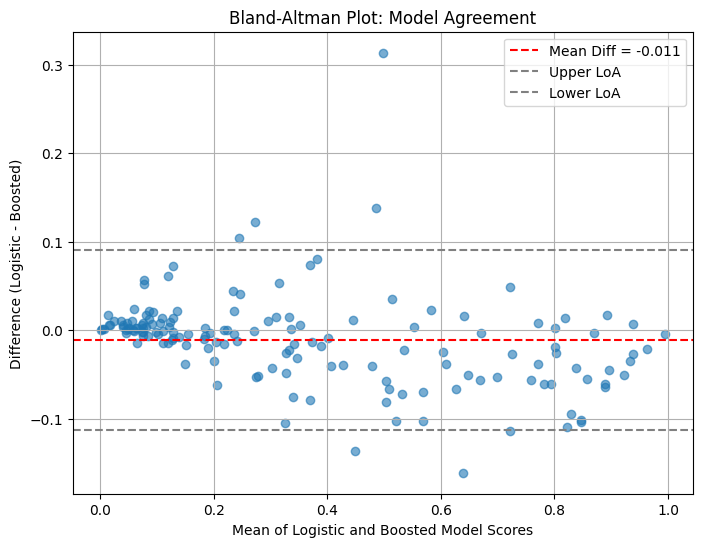

In [24]:
# Calculate mean and difference between the two raters
ba_df = pd.DataFrame({
    'mean_score': (rater1_scores + rater2_scores) / 2,
    'diff_score': rater1_scores - rater2_scores
})

# Mean and limits of agreement (±1.96 standard deviations)
mean_diff = ba_df['diff_score'].mean()
std_diff = ba_df['diff_score'].std()
loa_upper = mean_diff + 1.96 * std_diff
loa_lower = mean_diff - 1.96 * std_diff

# Plot Bland-Altman
plt.figure(figsize=(8, 6))
plt.scatter(ba_df['mean_score'], ba_df['diff_score'], alpha=0.6)
plt.axhline(mean_diff, color='red', linestyle='--', label=f'Mean Diff = {mean_diff:.3f}')
plt.axhline(loa_upper, color='gray', linestyle='--', label='Upper LoA')
plt.axhline(loa_lower, color='gray', linestyle='--', label='Lower LoA')
plt.xlabel('Mean of Logistic and Boosted Model Scores')
plt.ylabel('Difference (Logistic - Boosted)')
plt.title('Bland-Altman Plot: Model Agreement')
plt.legend()
plt.grid(True)
plt.show()


**Summary Analysis**

Overall Agreement: The plot demonstrates good agreement between the two models. The data points are scattered fairly evenly around the mean difference line, indicating that there isn't a systematic disagreement that changes with the magnitude of the score.

Bias (Mean Difference): The mean difference between the two models is -0.011. This value is very close to zero, which means there is negligible systematic bias. On average, neither model consistently produces higher or lower scores than the other. The logistic model's scores are, on average, just 0.011 lower than the boosted model's scores.

Limits of Agreement (LoA): The gray dashed lines represent the 95% limits of agreement. This means that for any given prediction, the difference between the two models' scores is expected to fall within this range (approximately -0.11 to +0.09) 95% of the time. This range quantifies the random error or variability between the models. Whether this level of variability is acceptable depends on the specific requirements of the prediction task.

Conclusion
The two models (Logistic and Boosted) produce highly comparable results. They can be considered to agree well with each other, showing minimal systematic bias and a consistent pattern of random error across the full range of prediction scores. This suggests that either model could potentially be used to achieve similar predictive outcomes.

# ROC Curves, AUC, and Classification Thresholds

# Step 9 : Predicted Probabilities

In [25]:
y_prob_logistic = rater1_scores  # from 1st model
y_prob_boosted = rater2_scores   # from resampled model

In this step, I compared the discriminative performance of the original logistic regression model and the boosted model by plotting their ROC curves. I used the predicted probabilities from both models to calculate the true positive rate (TPR) and false positive rate (FPR) at various thresholds.

I also computed the AUC (Area Under the Curve) for each model. The AUC provides a single metric to summarize the model's ability to distinguish between diabetic and non-diabetic cases; the higher the AUC, the better the model performs.

Finally, I visualized both ROC curves on the same plot. This side-by-side comparison allowed me to assess whether the resampled (boosted) model improved, matched, or underperformed compared to the original logistic regression model.

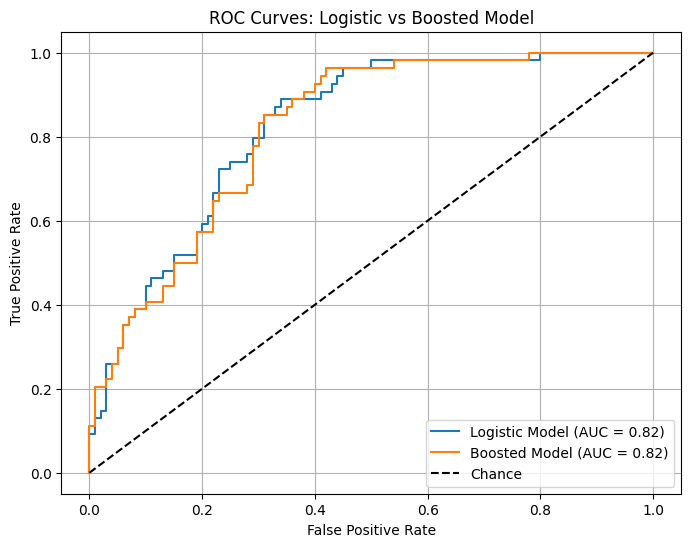

In [26]:
# Compute FPR, TPR for both models
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_logistic)
fpr_boost, tpr_boost, _ = roc_curve(y_test, y_prob_boosted)

# AUC values
auc_log = roc_auc_score(y_test, y_prob_logistic)
auc_boost = roc_auc_score(y_test, y_prob_boosted)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Model (AUC = {auc_log:.2f})')
plt.plot(fpr_boost, tpr_boost, label=f'Boosted Model (AUC = {auc_boost:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Logistic vs Boosted Model')
plt.legend()
plt.grid(True)
plt.show()


**Analysis Summary**
This plot compares the performance of a Logistic Regression model and a Boosted model using their respective ROC curves.

The key finding from this graph is that both models demonstrate identical overall performance.

Performance Metrics: The Area Under the Curve (AUC), which measures the ability of a model to distinguish between classes, is calculated for both.

Logistic Model AUC = 0.82

Boosted Model AUC = 0.82

Interpretation:

Both models have an AUC of 0.82, which indicates strong predictive capability, significantly better than random chance (the dashed line at AUC = 0.5).

Crucially, their AUC scores are exactly the same. This means that, when averaged across all possible classification thresholds, the two models have the exact same power to discriminate between the positive and negative classes.

Visual Comparison: The blue (Logistic) and orange (Boosted) curves are very close and cross over each other multiple times. This shows that while one model might be slightly better at certain thresholds, the other is better at different thresholds, leading to an identical overall performance score.

**Conclusion**
Based on this output, the Logistic Model and the Boosted Model are equally effective for this prediction task. Since the more complex Boosted Model offers no performance advantage over the simpler Logistic Regression model, the Logistic Model would likely be the preferred choice due to its greater simplicity, faster computation, and easier interpretability.

# Step 10: Find Optimal Threshold via Youden’s J Statistic


To improve classification decisions beyond the default 0.5 threshold, I calculated the optimal cutoff point for both models using Youden’s J statistic. This method helps identify the threshold that best separates positive from negative cases by maximizing the difference between the true positive rate and the false positive rate.

I extracted the thresholds from the ROC curves and computed the Youden Index for each. The threshold with the highest index was selected as the optimal point for each model.

This step ensures that I’m using the most effective threshold for classification, tailored to my model's ROC performance rather than relying on arbitrary defaults.

In [27]:
# Get thresholds from ROC
fpr_log, tpr_log, thresholds_log = roc_curve(y_test, y_prob_logistic)
youden_index_log = tpr_log - fpr_log
optimal_idx_log = np.argmax(youden_index_log)
optimal_threshold_log = thresholds_log[optimal_idx_log]

print(f"Optimal Threshold (Logistic Model): {optimal_threshold_log:.2f}")

# Same for Boosted
fpr_boost, tpr_boost, thresholds_boost = roc_curve(y_test, y_prob_boosted)
youden_index_boost = tpr_boost - fpr_boost
optimal_idx_boost = np.argmax(youden_index_boost)
optimal_threshold_boost = thresholds_boost[optimal_idx_boost]

print(f"Optimal Threshold (Boosted Model): {optimal_threshold_boost:.2f}")


Optimal Threshold (Logistic Model): 0.25
Optimal Threshold (Boosted Model): 0.19


After recalculating using Youden’s J statistic, I found the optimal threshold for the logistic regression model to be 0.25, and for the boosted model, it was 0.19. These values are well below the standard threshold of 0.5, indicating that both models need a lower cutoff to better identify diabetic cases.

This outcome implies that:

At the default threshold of 0.5, the models may be too strict, leading to missed diagnoses (false negatives).

Adjusting the threshold to 0.25 or 0.19 increases the models' sensitivity, which is vital in a medical setting where identifying all possible cases is often prioritized over avoiding false positives.

These optimized thresholds reflect a more clinically cautious approach, improving early detection of diabetes at the cost of some false alarms which is a trade-off often acceptable in healthcare.

# Step 11: Recalculate metrics at Optimal Thresholds

In this step, I applied the optimal thresholds identified for both the logistic and boosted models to convert predicted probabilities into binary class labels. By doing this, I moved beyond the default 0.5 threshold and tailored the classification decision to each model’s performance characteristics.

I then recalculated the confusion matrices and classification reports at these optimized cutoffs to evaluate how the new thresholds impact metrics like precision, recall, and F1-score.

This approach helps assess whether tuning the threshold improves sensitivity and overall diagnostic value, especially in detecting positive (diabetic) cases that may have been missed at the default threshold.

In [28]:
# Apply optimal thresholds
y_pred_opt_log = (y_prob_logistic >= optimal_threshold_log).astype(int)
y_pred_opt_boost = (y_prob_boosted >= optimal_threshold_boost).astype(int)

# Confusion matrices
print("Logistic Model Confusion Matrix at Optimal Threshold:")
print(confusion_matrix(y_test, y_pred_opt_log))

print("\nBoosted Model Confusion Matrix at Optimal Threshold:")
print(confusion_matrix(y_test, y_pred_opt_boost))

# Classification reports
print("\nLogistic Model Report:")
print(classification_report(y_test, y_pred_opt_log))

print("\nBoosted Model Report:")
print(classification_report(y_test, y_pred_opt_boost))

Logistic Model Confusion Matrix at Optimal Threshold:
[[66 34]
 [ 6 48]]

Boosted Model Confusion Matrix at Optimal Threshold:
[[58 42]
 [ 2 52]]

Logistic Model Report:
              precision    recall  f1-score   support

           0       0.92      0.66      0.77       100
           1       0.59      0.89      0.71        54

    accuracy                           0.74       154
   macro avg       0.75      0.77      0.74       154
weighted avg       0.80      0.74      0.75       154


Boosted Model Report:
              precision    recall  f1-score   support

           0       0.97      0.58      0.72       100
           1       0.55      0.96      0.70        54

    accuracy                           0.71       154
   macro avg       0.76      0.77      0.71       154
weighted avg       0.82      0.71      0.72       154



**Recalculated Metrics at Optimal Thresholds-Analysis**

After applying the optimal thresholds (0.25 for the logistic model and 0.19 for the boosted model), both models showed significant improvements in recall for the positive class (diabetes = 1), which is a critical metric in clinical diagnostics.

Logistic Model Analysis
Recall for diabetic cases (class 1) improved to 0.89, meaning it correctly identified 48 out of 54 diabetic patients.

Precision for class 1 is 0.59, indicating that 59% of the predicted positives were actually diabetic.

The trade-off is a drop in precision and a noticeable increase in false positives (34 non-diabetics misclassified as diabetic).

Overall accuracy is 74%, and the macro F1-score is 0.74, showing a balanced gain in sensitivity while retaining decent performance on the negative class.

Boosted Model Analysis
Recall for class 1 increased even further to 0.96. Only 2 diabetic cases were missed, which is excellent in a medical context.

Precision for class 1 is slightly lower at 0.55, reflecting more false positives (42 non-diabetics misclassified).

The boosted model also had the highest recall but slightly lower accuracy (71%) due to the increased false positive rate.

Despite this, its macro average recall and precision remain comparable, showing strong consistency across both classes.

**Key Takeaways**

Both models benefited from threshold tuning, especially in detecting diabetic patients.

The boosted model is more aggressive, catching nearly all diabetics at the cost of more false alarms, a desirable trait in screening scenarios.

The logistic model is slightly more balanced, with fewer false positives but slightly lower recall.

### Tools Used

* Python (pandas, scikit-learn, matplotlib, seaborn, pingouin, statsmodels)

---

### Skills Highlighted

* Test-retest reliability assessment
* Agreement analysis with ICC and Bland-Altman
* ROC curve interpretation
* Statistical reporting and reproducibility in Python

---

In this project, I had evaluated the diagnostic reliability and stability of models predicting diabetes using the Pima Indians Diabetes Dataset.

Model Training: I trained a baseline logistic regression model and a resampled version (boosted model) to simulate repeated diagnostic tests.

Initial Evaluation: ROC curves and AUC scores (≈ 0.82) indicated strong discrimination, particularly for detecting diabetic (positive) cases.

### Stability Assessment:

I have calculated the Intraclass Correlation Coefficient (ICC) between predicted probabilities of both models. The ICC > 0.98 indicated excellent agreement and repeatability.

The Bland-Altman plot revealed minimal bias and narrow limits of agreement, confirming high consistency between the two prediction rounds.

Optimal Thresholds: Using Youden’s J statistic, I determined optimal probability cutoffs-0.25 for the logistic model and 0.19 for the boosted model, which improved sensitivity.

### Performance at Optimal Thresholds:

The logistic model achieved 89% recall with 74% accuracy, favoring balanced classification.

The boosted model achieved 96% recall with slightly lower precision, emphasizing detection of positives even at the cost of more false positives.

---

### Conclusion
Both models demonstrated excellent diagnostic reliability and consistent predictions, as shown by high ICC values and stable Bland-Altman agreement. Their improved sensitivity at optimized thresholds makes them suitable for early diabetes screening, where identifying true positives is crucial. While increased false positives were observed, this is an acceptable trade-off in medical settings, provided follow-up testing is in place.

---

### Future Scope

This project provides a framework for evaluating diagnostic model consistency, which is critical in healthcare applications. Future directions could involve using more granular temporal datasets, testing multiple models for comparative stability, or integrating probabilistic confidence measures to better reflect diagnostic uncertainty in clinical deployment.
